In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Useful Functions

In [2]:
def ax_standard(ax):

    ax.grid(True, alpha=0.5)
    ax.set_xlabel("Epoch")

def plot_results(history):

    line_color = "#f07167"

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.tight_layout(pad=5)

    ax[0].plot(history["loss"], color = line_color)
    ax_standard(ax[0])
    ax[0].set_ylabel("Total Loss")


    ax[1].plot(history["kl_loss"], color = line_color)
    ax_standard(ax[1])
    ax[1].set_ylabel("KL Loss")


    ax[2].plot(history["reconstruction_loss"], color = line_color)
    ax_standard(ax[2])
    ax[2].set_ylabel("Reconstruction Loss")

In [3]:
def plot_training_vs_validation_loss(history):
    """
    Plots the total loss, reconstruction loss, and KL divergence loss
    for both training and validation.

    Parameters:
    history: Keras history object containing training and validation loss values per epoch.
    """
    plt.figure(figsize=(10, 5))

    # Plot total loss
   # plt.plot(history.history["loss"], label="Train Loss", color="#545f66")
   # plt.plot(history.history["val_loss"], label="Validation Loss", color="#829399", linestyle="dashed")

    # Plot reconstruction loss
    plt.plot(history.history["reconstruction_loss"], label="Train Reconstruction Loss", color="#8BE4CB")
    #plt.plot(history.history["val_reconstruction_loss"], label="Validation Reconstruction Loss", color="#DAFA9E", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Reconstruction Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Plot KL loss
    plt.plot(history.history["loss"], label="Total Loss", color="#b1cc74")
    #plt.plot(history.history["val_kl_loss"], label="Validation KL Loss", color="#DAFA9E", linestyle="dashed")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Kl_loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(history.history["kl_loss"], label="KL Loss", color="#b1cc74")
    #plt.plot(history.history["val_kl_loss"], label="Validation KL Loss", color="#DAFA9E", linestyle="dashed")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Kl_loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (after training the VAE model)
# plot_training_vs_validation_loss(vae.history)  # Uncomment this after training is completed


In [4]:
latent_dim = 15

### Paper Immplementation

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.seed_generator = keras.random.SeedGenerator(3718)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        time_dim = ops.shape(z_mean)[1]
        dim = ops.shape(z_mean)[2]
        epsilon = tf.keras.backend.random_normal(shape=(batch,time_dim, dim)) #batch, time steps, latent dim
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Sampling_t1(layers.Layer):
      def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.seed_generator = keras.random.SeedGenerator(3718)

      def call(self, inputs):
          z_mean, z_log_var = inputs
          batch = ops.shape(z_mean)[0]
          #time_dim = ops.shape(z_mean)[1]
          dim = ops.shape(z_mean)[1]
          epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) #batch,  latent dim
          return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#dynamically for shape
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [6]:

import numpy as np
import tensorflow as tf

# Generate synthetic sine wave sequences
def generate_sine_data(num_samples=1000, sequence_length=200, noise_level=0.1):
    """
    Generate sine wave sequences with slight variations.
    num_samples: Number of sequences.
    sequence_length: Number of time steps per sequence.
    noise_level: Amplitude of added random noise.
    Returns: (num_samples, sequence_length, 1) shape dataset
    """
    X = []
    for _ in range(num_samples):
        freq = np.random.uniform(0.1, 0.5)  # Random frequency
        phase = np.random.uniform(0, np.pi)  # Random phase shift
        sequence = np.sin(np.linspace(0, 2 * np.pi * freq, sequence_length) + phase)
        sequence += np.random.normal(0, noise_level, sequence_length)  # Add noise
        X.append(sequence)

    X = np.array(X).reshape(num_samples, sequence_length, 1)  # Reshape for LSTM input
    return X

# Generate data
X_train = generate_sine_data(num_samples=1000)
X_val = generate_sine_data(num_samples=200)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(32)

print("Training Data Shape:", X_train.shape)  # (1000, 20, 1)
print("Validation Data Shape:", X_val.shape)  # (200, 20, 1)


Training Data Shape: (1000, 200, 1)
Validation Data Shape: (200, 200, 1)


Training Data Shape: (1000, 200, 1)
Validation Data Shape (200, 200, 1)


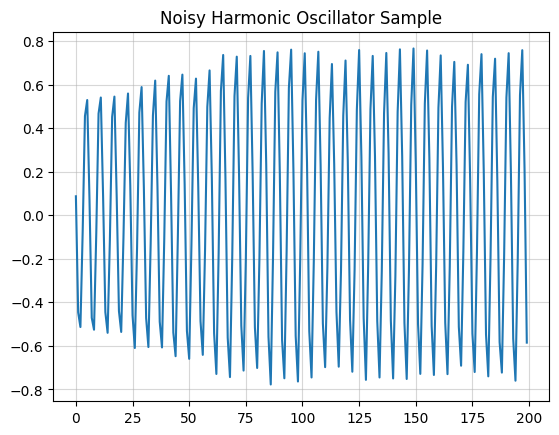

In [7]:
#Genearte noisy harmonic generator


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_harmonic_oscillator_data(num_samples=1000, sequence_length=200,
                                      mass=1.0, k_range=(0.5, 2.0),
                                      noise_level=0.05):
    """
    Generate noisy harmonic oscillator sequences.
    Returns: shape (num_samples, sequence_length, 1)
    """
    X = []
    np.random.seed(100)

    for _ in range(num_samples):
        # Random spring constant and angular frequency
        #k = np.random.uniform(*k_range)
        k = 1

        omega = np.sqrt(k / mass)

        # Initial conditions
        pos = np.zeros(sequence_length)
        vel = np.zeros(sequence_length)
        pos[0] = np.random.uniform(-1, 1)
        vel[0] = np.random.uniform(-1, 1)

        dt = 1.0
        for t in range(1, sequence_length):
            acc = - (k / mass) * pos[t - 1]

            #euler integration
            vel[t] = vel[t - 1] + dt * acc
            pos[t] = pos[t - 1] + dt * vel[t]

            # Add noise to velocity and position
            vel[t] += np.random.normal(0, noise_level)
            pos[t] += np.random.normal(0, noise_level)

        X.append(pos)

    X = np.array(X).reshape(num_samples, sequence_length, 1)
    return X

# Generate data
X_train = generate_harmonic_oscillator_data(num_samples=1000, noise_level=0.01)
X_val = generate_harmonic_oscillator_data(num_samples=200)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape", X_val.shape)
# Convert to TensorFlow dataset
#train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(32)

# Plot a sample
plt.plot(X_train[0])
plt.title("Noisy Harmonic Oscillator Sample")
plt.grid(True, alpha=0.5)
plt.show()


In [8]:
latent_dim = 15

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Generate data
X_train_np = generate_harmonic_oscillator_data(num_samples=1000, noise_level=0.01)
X_val_np = generate_harmonic_oscillator_data(num_samples=200, noise_level=0.01)

# Convert to tensors for pytorch
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)

# Wrap into datasets
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #shape 100 x 200 x 1
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) #shape 200 x 200 x 1

In [10]:
for batch in train_loader:
    x = batch[0]
    print(x.shape)

torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([40, 200, 1])


In [11]:
import torch
import numpy as np
import random
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


class MovingMNIST(torch.utils.data.Dataset):
    def __init__(self, num_sequences=1000, sequence_length=20, image_size=32, digit_size=28, speed=2):
        self.mnist = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        self.num_sequences = num_sequences
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.digit_size = digit_size
        self.speed = speed  # pixels/frame

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        canvas_size = self.image_size #32x32 looks similiar as in paper increase if required
        frames = np.zeros((self.sequence_length, canvas_size, canvas_size), dtype=np.float32)

        # Select a random MNIST digit
        digit_img, _ = self.mnist[random.randint(0, len(self.mnist) - 1)]
        digit_img = digit_img.squeeze(0).numpy()

        # Random direction: -1 (left) or +1 (right)
        direction = random.choice([-1, 1])
        dx = direction * self.speed  # no of pixel left/right

        # Random start
        x = random.randint(0, canvas_size - 1)
        y = random.randint(0, canvas_size - self.digit_size)
        #y = (canvas_size - self.digit_size) // 2  # center vertically if needed

        for t in range(self.sequence_length):
            x_int = int(np.floor(x)) % canvas_size  # wrap x using modulo

            # Handle wrap-around drawing
            if x_int + self.digit_size <= canvas_size:
                # Fully inside canvas
                frames[t, y:y+self.digit_size, x_int:x_int + self.digit_size] += digit_img
            else:
                # Split across right and left border
                right_part = canvas_size - x_int
                left_part = self.digit_size - right_part

                # Right slice
                frames[t, y:y+self.digit_size, x_int:] += digit_img[:, :right_part]
                # Left slice
                frames[t, y:y+self.digit_size, :left_part] += digit_img[:, right_part:]

            x += dx  # move with wrapping

        frames = np.clip(frames, 0, 1)
        frames = torch.tensor(frames).unsqueeze(1)  # shape: (T, 1, H, W)
        return frames


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.00MB/s]


torch.Size([20, 1, 32, 32])


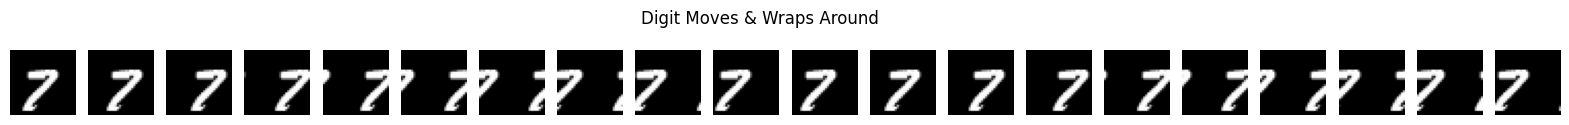

In [12]:
dataset = MovingMNIST(sequence_length=20, speed=3)
sequence = dataset[0]
print(sequence.shape)

def show_sequence(frames, title="Wrapped Digit Movement"):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 1.5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i, 0], cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

show_sequence(sequence, title="Digit Moves & Wraps Around")


In [13]:
# Generate data
X_train = MovingMNIST(num_sequences=1000,sequence_length=20, speed=3 )
X_val = MovingMNIST(num_sequences=200, sequence_length=20, speed=3)

# Create data loaders
train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
val_loader = DataLoader(X_val, batch_size=64, shuffle=False)



In [14]:
# Latent dynamics function in pytorch

import torch
import torch.nn as nn

class LatentDynamics(nn.Module):
    def __init__(self, latent_dim):
        super(LatentDynamics, self).__init__()
        self.latent_dim = latent_dim

        # Trainable diagonal of transition matrix A
        self.A_diag = nn.Parameter(torch.eye(latent_dim))

        # Trainable log of diagonal of covariance matrix
        self.log_cov_diag = nn.Parameter(torch.zeros(latent_dim))

    def forward(self, inputs=None):  # `inputs` kept for compatibility
        cov_diag = torch.exp(self.log_cov_diag)
        return self.A_diag, cov_diag


In [15]:
latent_dynamics = LatentDynamics(latent_dim)
A_diag, cov_diag = latent_dynamics()

A_diag.shape, cov_diag.shape

(torch.Size([15, 15]), torch.Size([15]))

In [16]:
import random

In [17]:
def time_interval():

  prob = random.random()
  if prob < 0.8: #time interval [1,10] with prob 0.8
    t2 = random.randint(10,199) # max time interval is 10, so if t2 < 10 t1 will be negative if dt = 10
    t1 = random.randint(t2-10,t2-1)
  else: #time interval [1,120] with prob 0.2
    t2 = random.randint(120,199)
    t1 = random.randint(t2-120,t2-1)
    print(t1)
  return t1, t2

def log_normal_pdf(x, mean, logvar):
  return - 0.5 *(
      tf.reduce_sum(tf.math.log(2. * np.pi) + logvar + tf.square(x - mean)/ tf.exp(logvar), axis = -1)
  )

def A_poly(A, power):
    r""""
    Returns a decresing polynomial in powers of A.
    Ex: For power = 3, returns A^3 + A^2 + A + 1
    """
    if power == 0: return 1
    return pow(A,power) + A_poly(A, power-1)



In [28]:
#Sampling example
for batch in train_loader:
    x = batch
    print(x.shape)
    print(x[:, 13, :,:,:].shape)
    break


torch.Size([64, 20, 1, 32, 32])
torch.Size([64, 1, 32, 32])


In [34]:

#Pytorch implementation

import torch
import torch.nn as nn

class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_var):
        eps = torch.randn_like(z_mean)
        return z_mean + eps * torch.exp(0.5 * z_log_var)

class Encoder(nn.Module):
    """
    Input: (B, T, 1, H, W) = (64, 20, 1, 32, 32)
    Output: (B, T, latent_dim) = (64, 20, 15)
    """
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.image_encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),   # [B, 1, 20, 32, 32] -> [B, 32, 10, 16, 16]
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # -> [B, 64, 5, 8, 8]
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), # -> [B, 128, 3, 4, 4]
            nn.ReLU(),
            nn.Flatten(),                                           # -> [B, 128*3*4*4] = [B, 6144]
        )

        self.fc_bt = nn.Linear(6144, 20 * 32)          # -> [B, 640]
        self.z_mean_t = nn.Linear(32, latent_dim)      # -> [B, 20, 15]
        self.z_log_var_t = nn.Linear(32, latent_dim)   # -> [B, 20, 15]
        self.sampling = Sampling()

    def forward(self, x):  # x: (B, T, 1, 32, 32)
        x = x.permute(0, 2, 1, 3, 4)    # -> (B, 1, T, H, W)
        x = self.image_encoder(x)      # -> (B, 6144)
        x = self.fc_bt(x)              # -> (B, 640)
        bt = x.view(-1, 20, 32)        # -> (B, 20, 32)

        z_mean = self.z_mean_t(bt)     # -> (B, 20, 15)
        z_log_var = self.z_log_var_t(bt)  # -> (B, 20, 15)
        zt = self.sampling(z_mean, z_log_var)  # -> (B, 20, 15)

        return z_mean, z_log_var, zt, bt

In [35]:
## checking dimensions of the encoder

# Instantiate the model
encoder = Encoder(latent_dim=15)

# Set model to eval mode (optional for testing)
encoder.eval()

# Get one batch from the DataLoader
for batch in train_loader:
    x = batch  # shape: [64, 20, 1, 32, 32]
    print("Input data shape:", x.shape)
    # Forward pass through encoder
    with torch.no_grad():  # disable gradient computation for testing
        z_mean, z_log_var, zt, bt = encoder(x)

    print("z_mean shape:", z_mean.shape)       # Expected: [64, 20, 15]
    print("z_log_var shape:", z_log_var.shape) # Expected: [64, 20, 15]
    print("zt shape:", zt.shape)               # Expected: [64, 20, 15]
    print("bt shape:", bt.shape)               # Expected: [64, 20, 32]

    break  # just one batch


Input data shape: torch.Size([64, 20, 1, 32, 32])
z_mean shape: torch.Size([64, 20, 15])
z_log_var shape: torch.Size([64, 20, 15])
zt shape: torch.Size([64, 20, 15])
bt shape: torch.Size([64, 20, 32])


In [33]:
class Decoder(nn.Module):
    """
    Input: (B, latent_dim) = (64, 15)
    Output: (B, 1, 32, 32)
    """
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        # Project latent vector to feature map: [B, 128, 4, 4]
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)  # (64, 15) → (64, 2048)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 128, 4, 4) → (64, 64, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (64, 64, 8, 8) → (64, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # (64, 32, 16, 16) → (64, 1, 32, 32)
            nn.Sigmoid()  # constrain output pixel values to [0,1]
        )

    def forward(self, z):
        # z: (64, 15)
        x = self.fc(z)                   # → (64, 2048)
        x = x.view(-1, 128, 4, 4)        # → (64, 128, 4, 4)
        x = self.decoder(x)             # → (64, 1, 32, 32)
        return x

In [37]:
## checking dimensions of the encoder

# Instantiate the model
encoder = Encoder(latent_dim=15)

# Set model to eval mode (optional for testing)
encoder.eval()

# Get one batch from the DataLoader
for batch in train_loader:
    x = batch  # shape: [64, 20, 1, 32, 32]
    print("Input data shape:", x.shape)
    # Forward pass through encoder
    with torch.no_grad():  # disable gradient computation for testing
        z_mean, z_log_var, zt, bt = encoder(x)

    print("z_mean shape:", z_mean.shape)       # Expected: [64, 20, 15]
    print("z_log_var shape:", z_log_var.shape) # Expected: [64, 20, 15]
    print("zt shape:", zt.shape)               # Expected: [64, 20, 15]
    print("bt shape:", bt.shape)               # Expected: [64, 20, 32]


    decoder_input = zt[:,15,:]
    print("decoder_input shape:", decoder_input.shape)
    decoder = Decoder(latent_dim=15)
    reconstruction = decoder(decoder_input)
    print("reconstruction shape:", reconstruction.shape)
    break  # just one batch


Input data shape: torch.Size([64, 20, 1, 32, 32])
z_mean shape: torch.Size([64, 20, 15])
z_log_var shape: torch.Size([64, 20, 15])
zt shape: torch.Size([64, 20, 15])
bt shape: torch.Size([64, 20, 32])
decoder_input shape: torch.Size([64, 15])
reconstruction shape: torch.Size([64, 1, 32, 32])


In [38]:
class Smoothing(nn.Module):
    def __init__(self, latent_dim):
        super(Smoothing, self).__init__()
        input_dim = latent_dim + 32 + 32 + 1  # z_t2 + b_t1 + b_t2 + delta_t

        self.qs_mean_t1 = nn.Linear(input_dim, latent_dim)  # 80 → 15 64x15
        self.qs_log_var_t1 = nn.Linear(input_dim, latent_dim)  # 80 → 15 64x15
        self.sampling = Sampling()

    def forward(self, smoothing_input):
        # smoothing_input shape: (batch, latent_dim + 32 + 32 + 1)
        qs_mean = self.qs_mean_t1(smoothing_input)      # (batch, latent_dim)  # (64, 15)
        qs_log_var = self.qs_log_var_t1(smoothing_input)  # (64, 15)
        zt1 = self.sampling(qs_mean, qs_log_var)        # (batch, latent_dim)  # (64, 15)

        return zt1, qs_mean, qs_log_var #all have shape = (latent_dim)


In [39]:
import torch
import torch.nn as nn

class Transition(nn.Module):
    def __init__(self, latent_dim):
        super(Transition, self).__init__()
        input_dim = latent_dim + 1  # z_t1 + delta_t

        self.pt_mean_t1 = nn.Linear(input_dim, latent_dim)
        self.pt_log_var_t1 = nn.Linear(input_dim, latent_dim)

    def forward(self, transition_input):
        # transition_input shape: (batch, latent_dim + 1)
        pt_mean = self.pt_mean_t1(transition_input)      # (batch, latent_dim)
        pt_log_var = self.pt_log_var_t1(transition_input)
        return pt_mean, pt_log_var


In [40]:
def log_normal_pdf(x, mean, logvar, eps=1e-6):
    log_two_pi = torch.log(torch.tensor(2. * math.pi, device=x.device, dtype=x.dtype))
    return -0.5 * torch.sum(
        log_two_pi + logvar + ((x - mean) ** 2) / (torch.exp(logvar) + eps),
        dim=-1
    )

def A_poly(A, power):
    """
    Returns A^power + A^(power-1) + ... + A + I
    """
    if power == 0:
        return torch.eye(A.size(0), device=A.device, dtype=A.dtype)  # Identity matrix
    result = torch.zeros_like(A)
    for i in range(power + 1):
        result += torch.matrix_power(A, i)
    return result


In [41]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, encoder, decoder, smoothing, transition, latent_dim, transition_matrix_A, prior_covariance, Markov_Prior=0):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.smoothing = smoothing
        self.transition = transition
        self.Markov_Prior = Markov_Prior

        self.A = transition_matrix_A  # shape: (latent_dim, latent_dim)
        self.cov = prior_covariance   # shape: (latent_dim,) or (latent_dim, latent_dim)

        # You can track losses using simple Python variables in your training loop
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    def reset_loss_trackers(self):
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data, optimizer, device):

      data = data.to(device)

      if self.Markov_Prior == 1:
          # === Markov Prior ===
          z_mean, z_log_var, z, bt = self.encoder(data)

          t1, t2 = time_interval()
          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)
          dt = (t2 - t1) * torch.ones((bt1.shape[0], 1), device=device) #(64,1)

          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt), dim=-1) # (64, 80) → (64, 15)
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs) #(64,15) each


          #A_pow = self.A.to(device) ** (t2 - t1)
          A_pow = torch.matrix_power(self.A, t2 - t1)
          pt_mean = zt1 @ A_pow.T   # (64, 15) @ (15, 15).T → (64, 15) Matrix multiplication
          pt_log_var = torch.log(self.cov) * A_poly(self.A, t2 - t1 - 1)

      else:
          # === Non-Markov ===
          z_mean, z_log_var, z, bt = self.encoder(data) #64x20x1x32x32 - 64x20x15

          t1, t2 = time_interval()
          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)
        #   dt = (t2 - t1) * torch.ones((bt1.shape[0], 1), device=device) #(64,1)
          dt = torch.full((x.size(0), 1), t2 - t1, dtype=bt1.dtype, device=x.device) #(64,1)

          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt), dim=-1)   #(64,80)
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs)  #(64,15) each

          trans_input = torch.cat((zt1, dt), dim=-1) #(64, 15 + 1) = (64, 16)
          pt_mean, pt_log_var = self.transition(trans_input) #(64 x 15) each

      # === Decoder ===
      reconstruction = self.decoder(zt2) #(64,15) - (64,1,32,32)
      target = data[:, t2, :] #(64,1,32,32)

      # === Losses ===
      mse = torch.nn.MSELoss()
      reconstruction_loss = mse(reconstruction, target)

      log_pzt1_bt1 = log_normal_pdf(zt1, z_mean[:, t1, :], z_log_var[:, t1, :])#.sum(dim=1)
      log_pzt2_zt1 = log_normal_pdf(zt2, pt_mean, pt_log_var)#.sum(dim=1)
      log_pzt2_bt2 = log_normal_pdf(zt2, z_mean[:, t2, :], z_log_var[:, t2, :])#.sum(dim=1)
      log_qzt1_given_all = log_normal_pdf(zt1, qs_mean, qs_log_var)#.sum(dim=1)

      kl_loss = (log_pzt1_bt1 - log_qzt1_given_all).mean()
      total_kl = (log_pzt1_bt1 + log_pzt2_zt1 - log_pzt2_bt2 - log_qzt1_given_all).mean()

      total_loss = reconstruction_loss - total_kl

      # === Backward and optimize ===
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      # === Return metrics ===
      return {
          'loss': total_loss.item(),
          'reconstruction_loss': reconstruction_loss.item(),
          'kl_loss': -kl_loss.item()
      }

In [42]:
# Instances of the network classes

encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
smoothing = Smoothing(latent_dim)
transition = Transition(latent_dim)


In [45]:
# Testing the Network
import math


vae = VAE(encoder, decoder, smoothing, transition, latent_dim=3, transition_matrix_A=A_diag, prior_covariance=torch.ones(15), Markov_Prior=0)       # construct the model
vae.to(device)        # move to GPU/CPU
vae.train()           # <- do not remove or redefine this!
vae.reset_loss_trackers()

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for batch in train_loader:
    x = batch.to(device)
    print(x.shape)
    metrics = vae.train_step(x, optimizer, device)
    print(metrics)

torch.Size([64, 20, 1, 32, 32])
118


IndexError: index 118 is out of bounds for dimension 1 with size 20

In [44]:
num_epochs = 100  # You can change this
vae.train()  # Sets the model to training mode

for epoch in range(num_epochs):
    total_loss = 0.0
    total_rec = 0.0
    total_kl = 0.0
    num_batches = 0

    for batch in train_loader:
        x = batch[0].to(device)  # assuming DataLoader yields (x,)

        # Call your VAE's train_step method
        metrics = vae.train_step(x, optimizer, device)

        total_loss += metrics['loss']
        total_rec += metrics['reconstruction_loss']
        total_kl += metrics['kl_loss']
        num_batches += 1

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/num_batches:.4f} | "
          f"Recon Loss: {total_rec/num_batches:.4f} | KL Loss: {total_kl/num_batches:.4f}")


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 5

In [ ]:
"""
# Instance of the pytorch classes
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
smoothing = Smoothing(latent_dim)
transition = Transition(latent_dim)



vae = VAE(encoder, decoder, smoothing, transition, latent_dim, A, cov, 1)
vae.compile(optimizer=keras.optimizers.Adam())

# try:
#     vae.set_weights(initial_weights)
# except:
#     initial_weights = vae.get_weights()

vae.fit(X_train, epochs=266, batch_size=128)#, validation_data=(X_val,X_val))

#vae.save_weights("markov_final_weights.weights.h5")
"""

In [ ]:
markov_history = np.load("markov_history.npy", allow_pickle=True).item()
dense_history = np.load("dense_history.npy", allow_pickle=True).item()

markov_history.keys()

In [ ]:
plot_results(markov_history)

In [ ]:
plot_results(dense_history)

In [ ]:
plot_training_vs_validation_loss(vae.history)

#Test

we pick time t1 = 60 and sample $z_{t_{1}}$ from $P_{b}(z_{t_{1}}|b_{t1})$.

In [ ]:
num_samples = 10
X_test = generate_sine_data(num_samples)
X_test = generate_harmonic_oscillator_data(num_samples)

In [ ]:
X_test.shape

In [ ]:
t1 = 60
z_mean, z_log_var, z, bt = encoder(X_test) # z shape = (1,200,latent dim)
zt1 = z[:,t1,:] #(num_samples,latent dim)
np.shape(zt1)

Then we choose the a time interval $δ_{t} = [20,100]$ to skip, sample from the forward model $P(z_{2} | z_1, δ_{t})$ to obtain $z_{t_{2}}$ at $t_2 = t_1 +  δ_{t}$

In [ ]:
def sample_gaussian(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
def mse_loss(x,z):
  return (x-z)**2


In [ ]:
from tqdm import tqdm

def dense_layer(X_test,t1,zt1):
  loss = []
  for dt in tqdm(range(20,139)):
    #for i in range(num_samples):
    dt1 = tf.fill([tf.shape(zt1)[0], 1], tf.cast(dt, dtype=zt1.dtype))

    zt2_mean, zt2_log_var = transition(tf.concat([zt1, dt1], axis=-1))
    zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      #my transition model doesnt sample so have to do it seperately

    xt2 = decoder(zt2)

    loss.append(np.mean(mse_loss(xt2, X_test[:,t1+dt])))



  return loss


def markov_prior(X_test,t1,zt1):
  trained_A = vae.A  # shape: (latent_dim,)
  trained_cov = vae.cov  # shape: (latent_dim,)
  loss = []
  for dt in tqdm(range(20,139)):
      zt2_mean = zt1 * tf.pow(trained_A, dt)  # element-wise multiplication
      zt2_log_var = tf.math.log(trained_cov)*A_poly(trained_A,dt-1)

      zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      xt2 = decoder(zt2)
      loss.append(np.mean(mse_loss(xt2, X_test[:,t1+dt])))


  return loss






In [ ]:
markov_loss = markov_prior(X_test,t1,zt1)

In [ ]:
from scipy.interpolate import UnivariateSpline
x = np.arange(20, len(markov_loss) + 20)
spline = UnivariateSpline(x, markov_loss, s=10)
markov_loss_smoothed = spline(x)

plt.plot(x, markov_loss, alpha = 0.25, color="#161a1d", label="Raw Results")
plt.plot(x, markov_loss_smoothed, color = "#e5383b", label="Spline Interpolation")
plt.grid(True, alpha=0.25)
plt.xlabel("Time Skip (dt)")
plt.ylabel("MSE Loss")
plt.title("Transition: Markov Prior")
plt.legend()
plt.show()

In [ ]:
dense_loss = dense_layer(X_test,t1,zt1)


In [ ]:
plt.plot(dense_loss)

In [ ]:
# Generate Sample Preds

def markov_gen(X_test,t1,zt1):
  trained_A = vae.A  # shape: (latent_dim,)
  trained_cov = vae.cov  # shape: (latent_dim,)
  loss = []
  for dt in tqdm(range(20,139)):
      zt2_mean = zt1 * tf.pow(trained_A, dt)  # element-wise multiplication
      zt2_log_var = tf.math.log(trained_cov)*A_poly(trained_A,dt-1)

      zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      xt2 = decoder(zt2)

  return xt2

preds_markov = markov_gen(X_test, t1, zt1)
preds_markov.shape


In [ ]:
plt.plot(X_test[0])